In [1]:
%load_ext autoreload
%autoreload 2

# ML Classifier Tests

## Setup

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from plotting_functions import my_mpl_settings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
# set the fonts for any plots you might make
my_mpl_settings()

In [6]:
data = pd.read_csv("../data/clean_all_data.csv")
print(f"Full dataset has {len(data)} entries")

Full dataset has 71871 entries


In [7]:
# replace infinities with NaN
data = data.replace([np.inf, -np.inf], np.nan)

data = data.dropna()
print(f"Full dataset has {len(data)} entries")

Full dataset has 71871 entries


## Fitting a Random Forest Classifier to the data

In [8]:
data.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads', 'dA_Om',
       'ligand_atoms', 'Si_count', 'dA_S', 'dA_Oat', 'A_T', 'neg_A_T', 'E_F',
       'dA_form_total', 'dA_fS', 'dA_fOat', 'dA_fOm', 'dE_Oa', 'dE_form_total',
       'dE_fS', 'dE_fOa', 'dE_fOm', 'lC_AOat', 'lC_AOm', 'lC_AS', 'lD_AOat',
       'lD_AOm', 'lD_AS', 'lC_AfOat', 'lC_AfOm', 'lC_AfS', 'lD_AfOat',
       'lD_AfOm', 'lD_AfS', 'lC_Oa', 'lC_Om', 'lC_S', 'lD_Oa', 'lD_Om', 'lD_S',
       'lC_fOa', 'lC_fOm', 'lC_fS', 'lD_fOa', 'lD_fOm', 'lD_fS'],
      dtype='object')

In [9]:
data_cols = [
    "Loading",
    "ligand_atoms",
    "Si_count",
    "E_F",
    "dE_Oa",
    "dE_Om",
    "dE_S",
    "dE_fOa",
    "dE_fOm",
    "dE_fS",
    "lC_Oa",
    "lC_Om",
    "lC_S",
    "lD_Oa",
    "lD_Om",
    "lD_S",
    "lC_fOa",
    "lC_fOm",
    "lC_fS",
    "lD_fOa",
    "lD_fOm",
    "lD_fS",
]

In [10]:
# Preprocess the data
# Example: Assuming 'synthesizable' is the target column and others are features
X = data[data_cols]
y = data["syn"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
weigh_dict = len(y_train) / (2 * np.bincount(y_train))
weigh_dict

array([ 0.51103921, 23.14653784])

In [12]:
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [None, 10, 20, 30],
    "criterion": ["gini", "entropy"],
}

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, class_weight="balanced")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=kf, scoring="accuracy", n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Print the best score
print(f"Best cross-validation score: {grid_search.best_score_}")

# Print cross-validation results
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean cross-validation score: {cv_scores.mean()}")
# print(f"Standard deviation of cross-validation scores: {cv_scores.std()}")

/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
31 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/ajhoffman/miniforge3/envs/htvs/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score: 0.9808160407143154


In [13]:
# Evaluate the model
w = len(y_test) / (y_test == 1).sum()
weights = w * y_test + 1
y_pred = best_model.predict(X_test)
print(f"Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, sample_weight=weights)}")
print(f"Recall: {recall_score(y_test, y_pred, sample_weight=weights)}")
print(f"F1 Score: {f1_score(y_test, y_pred, sample_weight=weights)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred, sample_weight=weights)}")

Accuracy: 0.5781026515442498
Precision: 0.9918555304242594
Recall: 0.15755627009646261
F1 Score: 0.27191831122213617
ROC-AUC: 0.5781026515442494


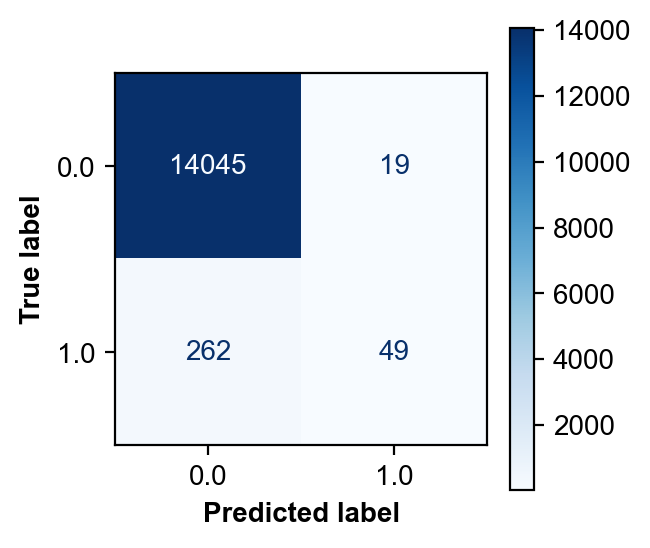

In [ ]:
# Plot a confusion matrix for the test set from the model
fig, ax = plt.subplots(figsize=(3, 3))
conmat = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues", ax=ax)
ax.set_xlabel("Predicted label", fontweight="bold")
ax.set_ylabel("True label", fontweight="bold")

plt.savefig("images/confusion_matrix.svg", dpi=300, bbox_inches="tight")

## Fit a neural network classifier to the data

In [15]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Create a dataset and split into training and validation sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [16]:
# Define the neural network
class SynthesizableNet(nn.Module):  # noqa: D101
    def __init__(self, input_dim):  # noqa: D107
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  # noqa: D102
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

In [17]:
# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]
model = SynthesizableNet(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    print(
        f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, "
        f"Validation Loss: {val_loss/len(val_loader):.4f}"
    )

Epoch 1/20, Training Loss: 0.0187, Validation Loss: 0.0992
Epoch 2/20, Training Loss: 0.0074, Validation Loss: 0.0901
Epoch 3/20, Training Loss: 0.0065, Validation Loss: 0.0879
Epoch 4/20, Training Loss: 0.0039, Validation Loss: 0.0866
Epoch 5/20, Training Loss: 0.0023, Validation Loss: 0.0813
Epoch 6/20, Training Loss: 0.0016, Validation Loss: 0.0820
Epoch 7/20, Training Loss: 0.0026, Validation Loss: 0.0818
Epoch 8/20, Training Loss: 0.0005, Validation Loss: 0.0829
Epoch 9/20, Training Loss: 0.0021, Validation Loss: 0.0772
Epoch 10/20, Training Loss: 0.0027, Validation Loss: 0.0771
Epoch 11/20, Training Loss: 0.0020, Validation Loss: 0.0783
Epoch 12/20, Training Loss: 0.0012, Validation Loss: 0.0779
Epoch 13/20, Training Loss: 0.0007, Validation Loss: 0.0769
Epoch 14/20, Training Loss: 0.0006, Validation Loss: 0.0760
Epoch 15/20, Training Loss: 0.0006, Validation Loss: 0.0768
Epoch 16/20, Training Loss: 0.0014, Validation Loss: 0.0756
Epoch 17/20, Training Loss: 0.0011, Validation Lo

In [19]:
# Evaluation on the validation set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(outputs.numpy())

# Convert predictions to binary
y_pred = np.array(y_pred)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_true)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9786


In [20]:
conf_matrix = confusion_matrix(y_true, y_pred_binary)

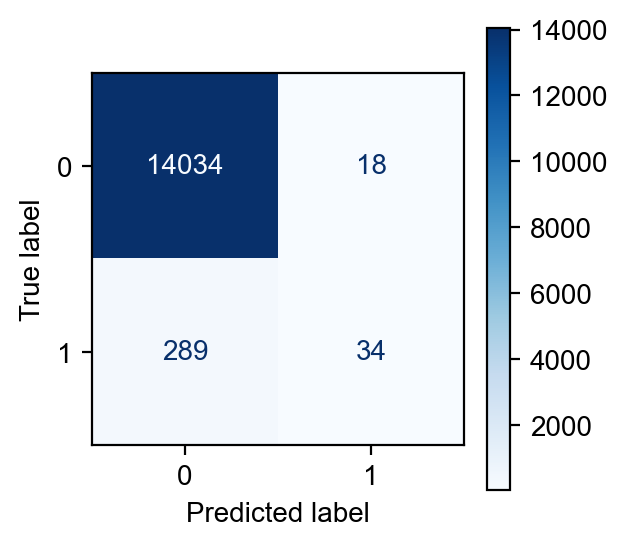

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("images/nn_confmat.svg", dpi=300, bbox_inches="tight")
plt.show()